## Analysis notebook - FOLD 0

### Imports

In [1]:
from bokeh.plotting import output_file, save
import json
import os
import pickle
from locpix_points.data_loading import datastruc
from locpix_points.scripts.visualise import visualise_torch_geometric, visualise_parquet, load_file
from locpix_points.scripts.featanalyse import (
    generate_umap_embedding,
    visualise_umap_embedding,
    generate_pca_embedding,
    visualise_pca_embedding,
    visualise_explanation,
    k_means_fn,
    get_prediction,
    subgraph_eval,
    pgex_eval,
    attention_eval,
)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import umap
import yaml

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:21: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Functions

In [2]:
def find_graph_path(project_directory, file_name, file_folder):
    """Visualise raw data
    
    Args:
        project_directory (string): Location of project directory
        file_name (string) : Name of file to image
        file_folder (string) : Which folder the file is in"""
    
    train_file_map_path = os.path.join(project_directory, f"{file_folder}/train/file_map.csv")
    val_file_map_path = os.path.join(project_directory, f"{file_folder}/val/file_map.csv")
    test_file_map_path = os.path.join(project_directory, f"{file_folder}/test/file_map.csv")
    
    train_file_map = pd.read_csv(train_file_map_path)
    val_file_map = pd.read_csv(val_file_map_path)
    test_file_map = pd.read_csv(test_file_map_path)
    
    train_out = train_file_map[train_file_map["file_name"] == file_name]
    val_out = val_file_map[val_file_map["file_name"] == file_name]
    test_out = test_file_map[test_file_map["file_name"] == file_name]
    
    if len(train_out) > 0:
        folder = "train"
        file_name = train_out["idx"].values[0]
    if len(val_out) > 0:
        folder = "val"
        file_name = val_out["idx"].values[0]
    if len(test_out) > 0:
        folder = "test"
        file_name = test_out["idx"].values[0]
    
    return os.path.join(project_directory, f"{file_folder}/{folder}/{file_name}.pt")

### Parameters

In [3]:
project_directory = ".."
# load config
with open(os.path.join(project_directory, "config/featanalyse_manual.yaml"), "r") as ymlfile:
    config_manual = yaml.safe_load(ymlfile)
with open(os.path.join(project_directory, "config/featanalyse_nn.yaml"), "r") as ymlfile:
    config_nn = yaml.safe_load(ymlfile)
label_map = config_manual["label_map"]
assert label_map == config_nn["label_map"]
manual_features = config_manual["features"]

In [4]:
final_test = False
umap_n_neighbours = 20
umap_min_dist = 0.5
pca_n_components = 2
device = 'cuda'

### Analyse the manual features

In [ ]:
train_df = os.path.join(project_directory, "output/train_df_manual.csv")
train_df = pl.read_csv(train_df)
train_df_pd = train_df.to_pandas()

if final_test:
    test_df = os.path.join(project_directory, "output/test_df_manual.csv")
    test_df = pl.read_csv(test_df)
    test_df_pd = test_df.to_pandas()

#### Compare PCA vs Convex hull

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=train_df_pd, x = "length_pca", y="length_convex_hull",s=5, ax=ax1)
sns.scatterplot(data=train_df_pd, x = "area_pca", y="area_convex_hull",s=5, ax=ax2)
plt.show()

if final_test:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    sns.scatterplot(data=test_df_pd, x = "length_pca", y="length_convex_hull",s=5, ax=ax1)
    sns.scatterplot(data=test_df_pd, x = "area_pca", y="area_convex_hull",s=5, ax=ax2)
    plt.show()

#### Cluster features boxplots

In [ ]:
# number of clusters per FOV, cluster type, ...
train_cluster_counts = train_df["file_name"].value_counts()
print("Number of clusters per FOV:", train_cluster_counts)
# number of clusters in each class
train_type_counts = train_df["type"].value_counts()
print("Number of clusters in each class:", train_type_counts)

# per fov features grouped by mean with std
train_df_boxplot = train_df[manual_features + ["type", "file_name"]].to_pandas()

fig, axs = plt.subplots(2,4, figsize=(20,8))
assert len(manual_features) == 8
counter = 0
for feat in manual_features:
    sns.boxplot(x='type', y=feat, data=train_df_boxplot, color='k', fill=False, flierprops=dict(marker='x', markersize=5), ax=axs[counter//4][counter%4])
    counter += 1
plt.show()


if final_test:
    # number of clusters per FOV, cluster type, ...
    test_cluster_counts = test_df["file_name"].value_counts()
    print("Number of clusters per FOV:", test_cluster_counts)
    # number of clusters in each class
    test_type_counts = test_df["type"].value_counts()
    print("Number of clusters in each class:", test_type_counts)

    # per fov features grouped by mean with std
    test_df_boxplot = test_df[manual_features + ["type", "file_name"]].to_pandas()

    fig, axs = plt.subplots(2,4, figsize=(20,8))
    assert len(manual_features) == 8
    counter = 0
    for feat in manual_features:
        sns.boxplot(x='type', y=feat, data=test_df_boxplot, color='k', fill=False, flierprops=dict(marker='x', markersize=5), ax=axs[counter//4][counter%4])
        counter += 1
    plt.show()
#

### Graph feature explainability

In [ ]:
# get features present in the dataframe
not_features = ["clusterID", "x_mean", "y_mean", "type", "file_name"]
features = [x for x in train_df.columns if x not in not_features]

# now remove features not selected by user
removed_features = [f for f in features if f not in manual_features]
print("Removed features: ", removed_features)
features = [f for f in features if f in manual_features]
print("Features analysed: ", features)

# feature vector
train_data_feats = train_df_pd[features].values
if final_test:
    test_data_feats = test_df_pd[features].values

num_features = len(train_data_feats[0])
print("Num features: ", num_features)
############ WARNING ##############
# Be careful, if analysing neural net features
# Is this the number of features you expect
# Did this task use manual features as well

scaler = StandardScaler().fit(train_data_feats)
X_train = scaler.transform(train_data_feats)
if final_test:
    X_test = scaler.transform(test_data_feats)

#### UMAP

In [ ]:
train_umap_embedding_manual_path = os.path.join(project_directory, "output/train_umap_embedding_manual.pkl")
test_umap_embedding_manual_path = os.path.join(project_directory, "output/test_umap_embedding_manual.pkl")

if not os.path.exists(train_umap_embedding_manual_path):
    train_umap_embedding = generate_umap_embedding(X_train, umap_min_dist, umap_n_neighbours)
    with open(train_umap_embedding_manual_path, "wb") as f:
        pickle.dump(train_umap_embedding, f)
    f.close()

if final_test:
    print("Final test")
    if not os.path.exists(test_umap_embedding_manual_path):
        test_umap_embedding = generate_umap_embedding(X_test, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_manual_path, "wb") as f:
            pickle.dump(test_umap_embedding, f)
        f.close()

In [ ]:
%matplotlib widget
with open(train_umap_embedding_manual_path, "rb") as f:
    train_umap_embedding = pickle.load(f)
visualise_umap_embedding(train_umap_embedding, train_df_pd, label_map)
if final_test:
    with open(test_umap_embedding_manual_path, "rb") as f:
        test_umap_embedding = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding, test_df_pd, label_map, save=False, save_name="manual_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)

#### PCA

In [ ]:
train_pca_embedding = generate_pca_embedding(X_train, pca_n_components)
if final_test:
    test_pca_embedding = generate_pca_embedding(X_test, pca_n_components)


In [ ]:
visualise_pca_embedding(train_pca_embedding, train_df_pd, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding, test_df_pd, label_map)

#### K-means

In [ ]:
k_means_fn(X_train, train_df_pd, label_map)
if final_test:
    k_means_fn(X_test, test_df_pd, label_map)

## Analyse the nn features

In [5]:
train_df_nn_loc = os.path.join(project_directory, "output/train_df_nn_loc.csv")
train_df_nn_loc = pd.read_csv(train_df_nn_loc)

train_df_nn_cluster = os.path.join(project_directory, "output/train_df_nn_cluster.csv")
train_df_nn_cluster = pd.read_csv(train_df_nn_cluster)

train_df_nn_fov = os.path.join(project_directory, "output/train_df_nn_fov.csv")
train_df_nn_fov = pd.read_csv(train_df_nn_fov)

if final_test:  
    test_df_nn_loc = os.path.join(project_directory, "output/test_df_nn_loc.csv")
    test_df_nn_loc = pd.read_csv(test_df_nn_loc)

    test_df_nn_cluster = os.path.join(project_directory, "output/test_df_nn_cluster.csv")
    test_df_nn_cluster = pd.read_csv(test_df_nn_cluster)

    test_df_nn_fov = os.path.join(project_directory, "output/test_df_nn_fov.csv")
    test_df_nn_fov = pd.read_csv(test_df_nn_fov)

else:
    test_df_nn_loc = None
    test_df_nn_cluster = None
    test_df_nn_fov = None


### Graph feature explainability

In [6]:
def prep_features(train_df, test_df):

    # get features present in the dataframe
    not_features = ["type", "file_name"]
    features = [x for x in train_df.columns.to_list() if x not in not_features]

    # feature vector
    train_data_feats_nn = train_df[features].values
    if final_test:
        test_data_feats_nn = test_df[features].values

    num_features = len(train_data_feats_nn[0])
    print("Num features: ", num_features)
    ############ WARNING ##############
    # Be careful, if analysing neural net features
    # Is this the number of features you expect
    # Did this task use manual features as well

    scaler = StandardScaler().fit(train_data_feats_nn)
    X_train_nn = scaler.transform(train_data_feats_nn)
    if final_test:
        X_test_nn = scaler.transform(test_data_feats_nn)
        
        return X_train_nn, X_test_nn
    else:
        return X_train_nn, None

X_train_nn_loc, X_test_nn_loc = prep_features(train_df_nn_loc, test_df_nn_loc)
X_train_nn_cluster, X_test_nn_cluster = prep_features(train_df_nn_cluster, test_df_nn_cluster)
X_train_nn_fov, X_test_nn_fov = prep_features(train_df_nn_fov, test_df_nn_fov)

Num features:  8
Num features:  40
Num features:  40


#### UMAP

In [7]:
train_umap_embedding_nn_loc_path = os.path.join(project_directory, "output/train_umap_embedding_nn_loc.pkl")
train_umap_embedding_nn_cluster_path = os.path.join(project_directory, "output/train_umap_embedding_nn_cluster.pkl")
train_umap_embedding_nn_fov_path = os.path.join(project_directory, "output/train_umap_embedding_nn_fov.pkl")

test_umap_embedding_nn_loc_path = os.path.join(project_directory, "output/test_umap_embedding_nn_loc.pkl")
test_umap_embedding_nn_cluster_path = os.path.join(project_directory, "output/test_umap_embedding_nn_cluster.pkl")
test_umap_embedding_nn_fov_path = os.path.join(project_directory, "output/test_umap_embedding_nn_fov.pkl")

if not os.path.exists(train_umap_embedding_nn_loc_path):
    train_umap_embedding_nn_loc = generate_umap_embedding(X_train_nn_loc, umap_min_dist, umap_n_neighbours)
    with open(train_umap_embedding_nn_loc_path, "wb") as f:
        pickle.dump(train_umap_embedding_nn_loc, f)
    f.close()
if not os.path.exists(train_umap_embedding_nn_cluster_path):
    train_umap_embedding_nn_cluster = generate_umap_embedding(X_train_nn_cluster, umap_min_dist, umap_n_neighbours)
    with open(train_umap_embedding_nn_cluster_path, "wb") as f:
        pickle.dump(train_umap_embedding_nn_cluster, f)
    f.close()
if not os.path.exists(train_umap_embedding_nn_fov_path):
    train_umap_embedding_nn_fov = generate_umap_embedding(X_train_nn_fov, umap_min_dist, umap_n_neighbours)
    with open(train_umap_embedding_nn_fov_path, "wb") as f:
        pickle.dump(train_umap_embedding_nn_fov, f)
    f.close()
if final_test:
    if not os.path.exists(test_umap_embedding_nn_loc_path):
        test_umap_embedding_nn_loc = generate_umap_embedding(X_test_nn_loc, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_loc_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_loc, f)
        f.close()
    
    if not os.path.exists(test_umap_embedding_nn_cluster_path):
        test_umap_embedding_nn_cluster = generate_umap_embedding(X_test_nn_cluster, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_cluster_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_cluster, f)
        f.close()

    if not os.path.exists(test_umap_embedding_nn_fov_path):
        test_umap_embedding_nn_fov = generate_umap_embedding(X_test_nn_fov, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_fov_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_fov, f)
        f.close()

------ LOC ENCODER -------


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:765: UserWarning: Will fail if too many points as has no collections[0], therefore set to interactive to avoid failing
  warnings.warn(


Too many points - replotting with matplotlib 


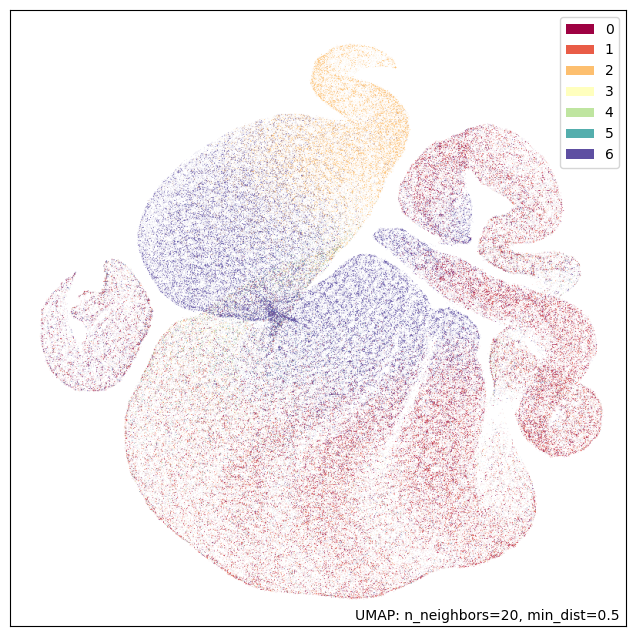

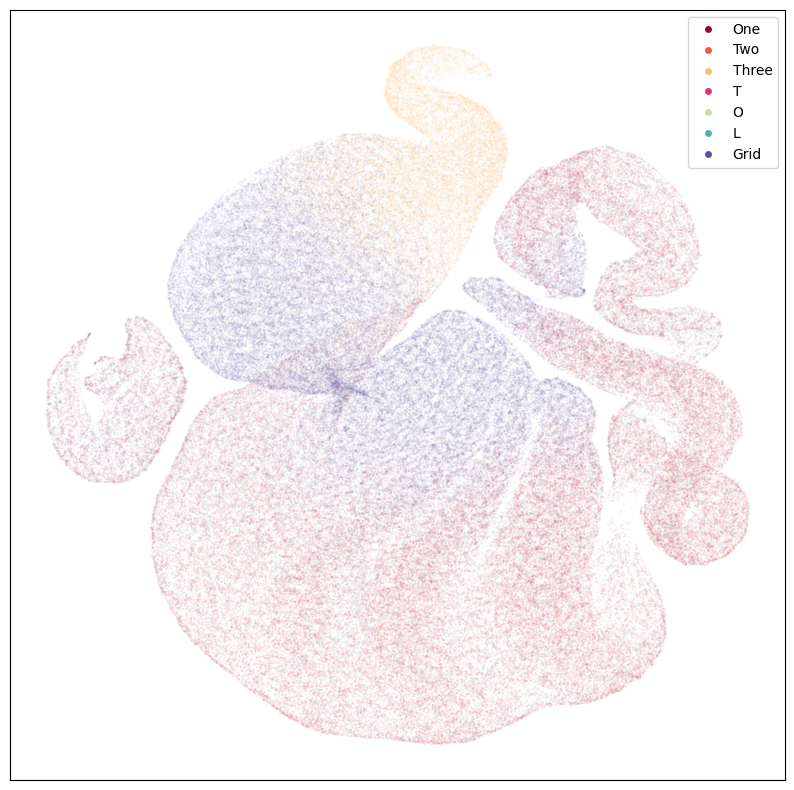

In [8]:
print("------ LOC ENCODER -------")
with open(train_umap_embedding_nn_loc_path, "rb") as f:
        train_umap_embedding_nn_loc = pickle.load(f)
visualise_umap_embedding(train_umap_embedding_nn_loc, train_df_nn_loc, label_map, save=True, save_name="nn_loc_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)
if final_test:
    with open(test_umap_embedding_nn_loc_path, "rb") as f:
        test_umap_embedding_nn_loc = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding_nn_loc, test_df_nn_loc, label_map, save=False, save_name="nn_loc_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)


------ CLUSTER ENCODER -------


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:765: UserWarning: Will fail if too many points as has no collections[0], therefore set to interactive to avoid failing
  warnings.warn(


Too many points - replotting with matplotlib 


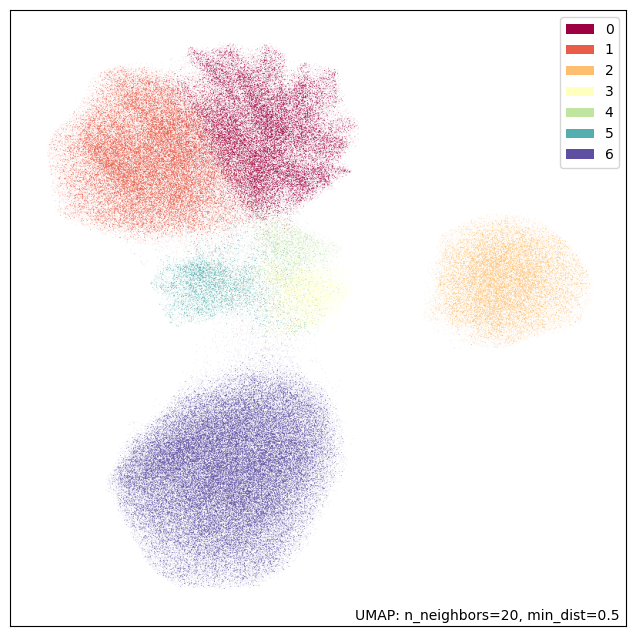

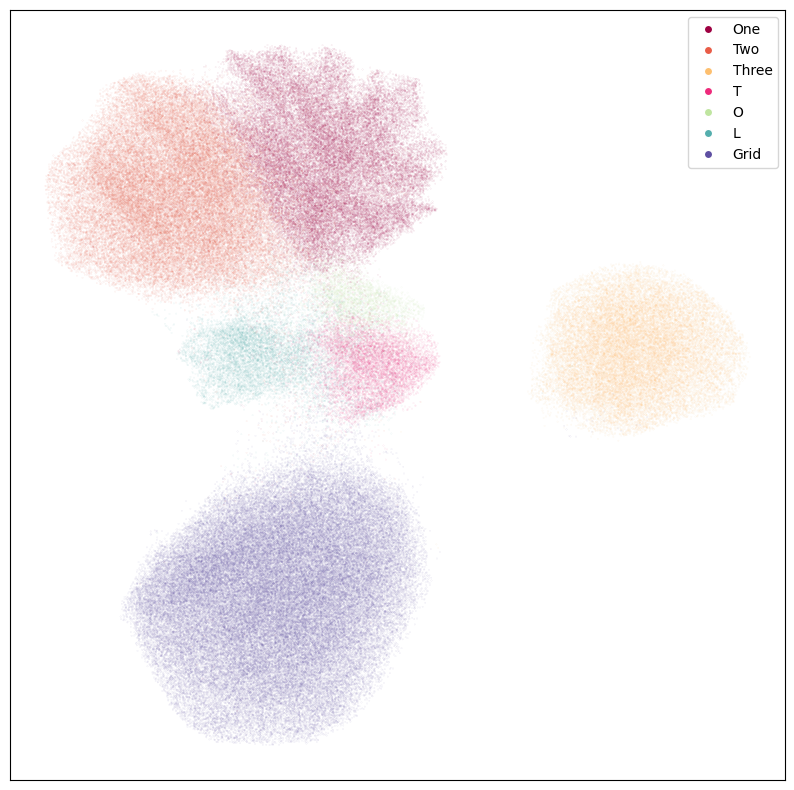

In [9]:
print("------ CLUSTER ENCODER -------")
with open(train_umap_embedding_nn_cluster_path, "rb") as f:
        train_umap_embedding_nn_cluster = pickle.load(f)
visualise_umap_embedding(train_umap_embedding_nn_cluster, train_df_nn_cluster, label_map, save=True, save_name="nn_cluster_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)
if final_test:
    with open(test_umap_embedding_nn_cluster_path, "rb") as f:
            test_umap_embedding_nn_cluster = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding_nn_cluster, test_df_nn_cluster, label_map, save=False, save_name="nn_cluster_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)

------ FOV ENCODER -------


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:765: UserWarning: Will fail if too many points as has no collections[0], therefore set to interactive to avoid failing
  warnings.warn(


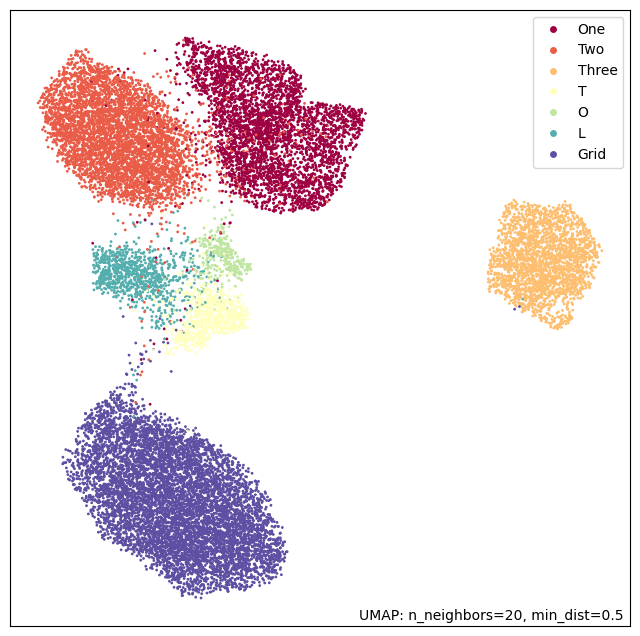

In [11]:
print("------ FOV ENCODER -------")
with open(train_umap_embedding_nn_fov_path, "rb") as f:
        train_umap_embedding_nn_fov = pickle.load(f)
visualise_umap_embedding(train_umap_embedding_nn_fov, train_df_nn_fov, label_map, save=True, save_name="nn_fov_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=1)
if final_test:
    with open(test_umap_embedding_nn_fov_path, "rb") as f:
        test_umap_embedding_nn_fov = pickle.load(f)
    plot = visualise_umap_embedding(test_umap_embedding_nn_fov, test_df_nn_fov, label_map, save=False, save_name="nn_fov_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory,interactive=True, point_size=5)
    if True:
        output_file_loc  = os.path.join(project_directory, "output", "nn_fov.html")
        output_file(output_file_loc)
        save(plot)

#### PCA

In [ ]:
train_pca_embedding_nn_loc = generate_pca_embedding(X_train_nn_loc, pca_n_components)
train_pca_embedding_nn_fov = generate_pca_embedding(X_train_nn_fov, pca_n_components)
train_pca_embedding_nn_cluster = generate_pca_embedding(X_train_nn_cluster, pca_n_components)
if final_test:
    test_pca_embedding_nn_loc = generate_pca_embedding(X_test_nn_loc, pca_n_components)
    test_pca_embedding_nn_fov = generate_pca_embedding(X_test_nn_fov, pca_n_components)
    test_pca_embedding_nn_cluster = generate_pca_embedding(X_test_nn_cluster, pca_n_components)

In [ ]:
print("------ LOC ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_loc, test_df_nn_loc, label_map)

In [ ]:
print("------ CLUSTER ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_cluster, test_df_nn_cluster, label_map)


In [ ]:
print("------ FOV ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_fov, test_df_nn_fov, label_map)

#### K-means

In [ ]:
print("----- LOC ------")
k_means_fn(X_train_nn_loc, train_df_nn_loc, label_map)
if final_test:
    k_means_fn(X_test_nn_loc, test_df_nn_loc, label_map)

print("----- CLUSTER ------")
k_means_fn(X_train_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    k_means_fn(X_test_nn_cluster, test_df_nn_cluster, label_map)

print("----- FOV ------")
k_means_fn(X_train_nn_fov, train_df_nn_fov, label_map)
if final_test:
    k_means_fn(X_test_nn_fov, test_df_nn_fov, label_map)


### Graph structure explainability

In [ ]:
# get item to evaluate on
file_name = "three_2296"

#### Load in configuration

In [ ]:
config_path = os.path.join(project_directory, "config/featanalyse_nn.yaml")
with open(config_path, "r") as ymlfile:
    config = yaml.safe_load(ymlfile)

# load in gt_label_map
metadata_path = os.path.join(project_directory, "metadata.json")
with open(
    metadata_path,
) as file:
    metadata = json.load(file)
    # add time ran this script to metadata
    gt_label_map = metadata["gt_label_map"]

fold = config["fold"]
gt_label_map = {int(key): val for key, val in gt_label_map.items()}

#### Visualise file

In [ ]:
if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"
visualise_file(project_directory, file_name, file_folder)

#### Load in cluster model

In [ ]:
cluster_model = torch.load(os.path.join(project_directory, f"output/cluster_model.pt"))
cluster_model.to(device)
cluster_model.eval()

#### Load datasets

In [ ]:
cluster_train_folder = os.path.join(project_directory, "processed/featanalysis/train")
cluster_val_folder = os.path.join(project_directory, "processed/featanalysis/val")
cluster_test_folder = os.path.join(project_directory, "processed/featanalysis/test")

if not final_test:
    loc_test_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "test"
    )
    loc_train_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "train"
    )
    loc_val_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "val"
    )

else:
    loc_test_folder = os.path.join(project_directory, "processed", "test")
    loc_train_folder = os.path.join(project_directory, "processed", "train")
    loc_val_folder = os.path.join(project_directory, "processed", "val")


cluster_train_set = datastruc.ClusterDataset(
    None,
    cluster_train_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

cluster_val_set = datastruc.ClusterDataset(
    None,
    cluster_val_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

cluster_test_set = datastruc.ClusterDataset(
    None,
    cluster_test_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

# localisations are yet to be passed through any network

loc_train_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_train_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)

loc_val_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_val_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)

loc_test_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_test_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)


#### Get items to evaluate on 

In [ ]:
cluster_dataitem, loc_dataitem, prediction = get_prediction(
    file_name,
    cluster_model, 
    cluster_train_set, 
    loc_train_set, 
    cluster_val_set, 
    loc_val_set, 
    cluster_test_set, 
    loc_test_set,
    project_directory,
    device, 
    gt_label_map)

#### SubgraphX

In [ ]:
subgraph_config = {
    # number of iterations to get prediction
    "rollout":  20,
    # number of atoms of leaf node in search tree
    "min_atoms": 5,
    # hyperparameter that encourages exploration
    "c_puct": 10.0,
    # number of atoms to expand when extend the child nodes in the search tree
    "expand_atoms": 14,
    # whether to expand the children nodes from high degreee to low degree when extend the child nodes in the search tree
    "high2low": False,
    # number of local radius to caclulate
    "local_radius": 4,
    # sampling time of montecarlo approxim
    "sample_num": 100,
    # reward method
    "reward_method": "mc_l_shapley",
    # subgrpah building method
    "subgraph_building_method": "split",
    # maximum number of nodes to include in subgraph when generating explanation
    "max_nodes": 8,
    # number of classes
    "num_classes": 7,
}

In [ ]:
 # ---- subgraphx -----
subgraphx_subgraph, subgraphx_complement, _, _ = subgraph_eval(cluster_model, device, subgraph_config, cluster_dataitem, prediction)
    

In [ ]:
# ---- visualise subgraphx subgraph ----
visualise_explanation(subgraphx_subgraph.pos, subgraphx_subgraph.edge_index)

In [ ]:
# ---- visualise subgraphx complement ----
visualise_explanation(subgraphx_complement.pos, subgraphx_complement.edge_index)

#### PgEx

In [ ]:
pgex_config = {
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.5,
}

In [ ]:
# ---- pgexplainer ----
pg_explainer = torch.load(os.path.join(project_directory, f"output/pg_explainer.pt")) 
pgex_eval(cluster_model, pg_explainer, cluster_dataitem, device, pgex_config)

#### Saliency

In [ ]:
saliency_config = {
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.5,
}

In [ ]:
# ---- saliency -----
saliency_subgraph, saliency_complement = saliency_eval(cluster_model, saliency_config, cluster_dataitem, device)

#### Attention

In [ ]:
attention_config = {
    #  scale: cluster # Options: [cluster] In future will also include [loc, loccluster]
    "scale": "cluster",
    #  # how to combine attention scores across multiple attention heads
    "reduce": "max",
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.6,
}

In [ ]:
# ---- attention -----
# use model - logprobs or clustermodel - raw
attention_subgraph, attention_complement, _, _ = attention_eval(cluster_model, attention_config, cluster_dataitem, device, loc_dataitem)

In [ ]:
# ---- visualise attention subgraph ----

## WARNING - self loops may be present but won't be visualised
# This will explain seemingly isolated nodes
visualise_explanation(attention_subgraph.pos, attention_subgraph.edge_index)

In [ ]:
# ---- visualise attention complement ----
## WARNING - self loops may be present but won't be visualised
# This will explain seemingly isolated nodes
visualise_explanation(attention_complement.pos, attention_complement.edge_index)

### Statistical tests

## To do

Monday/Tuesday
1. Test explainability stuff on task 1/2
2. Stat tests
3. Test on final test
4. Make sure if make any changes to notebook update the one in scripts
5. Merge pull request
